# Analysis of Bias and Variance in a linear regression model
In this notebook, using a salary prediction dataset called salary prediction dataset https://www.kaggle.com/datasets/rkiattisak/salaly-prediction-for-beginer 
,we will analyze the bias and prediction using different features of the dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from mlxtend.evaluate import bias_variance_decomp

In [2]:
# Read the data into a Pandas Dataframe

salary_data = pd.read_csv("data/Salary Data.csv")

In [3]:
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [4]:
# Check for missing values
salary_data.isnull().sum().sum()

12

In [5]:
# Drop any rows that have missing values
salary_data = salary_data.dropna()
salary_data.isnull().sum().sum()

0

### We want to build a regression model that can predict salary based on the following features:
- Age
- Educational Level
- Years of Experience
- Gender
- Job Title

In [6]:
# Let's examine the categorical columns
print(salary_data['Gender'].unique())
print(salary_data['Education Level'].unique())
print(salary_data['Job Title'])

['Male' 'Female']
["Bachelor's" "Master's" 'PhD']
0                  Software Engineer
1                       Data Analyst
2                     Senior Manager
3                    Sales Associate
4                           Director
                   ...              
370         Senior Marketing Analyst
371           Director of Operations
372           Junior Project Manager
373    Senior Operations Coordinator
374          Senior Business Analyst
Name: Job Title, Length: 373, dtype: object


### We will use LabelEncoder to conver Categorical values to numeric

In [7]:
# Encoder function
def Encoder (df):
    columnsToEncode = list(df.select_dtypes(include = ['category', 'object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

In [8]:
categorical_features = ['Gender', 'Education Level', 'Job Title']
salary_data = Encoder(salary_data)
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,1,0,159,5.0,90000.0
1,28.0,0,1,17,3.0,65000.0
2,45.0,1,2,130,15.0,150000.0
3,36.0,0,0,101,7.0,60000.0
4,52.0,1,1,22,20.0,200000.0


## Regression Model
### 1. Let's try with only one feature (input), for example years of experience 

In [9]:
df_binary = salary_data[['Years of Experience', 'Salary']]

### 1.1 Explore the data

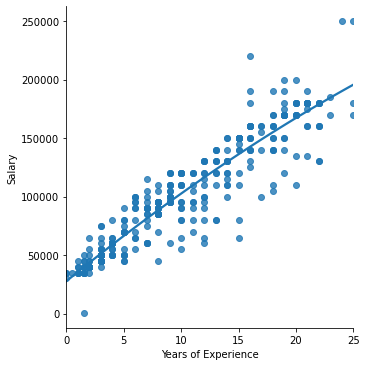

In [10]:
sns.lmplot(x = 'Years of Experience', y='Salary', data = df_binary, order = 2, ci = None)
plt.show()

### 1.2 Train our model

In [11]:
# Separate data into indpendent (X) and dependent variables 
# Convert the data frame into a numpy array since each dataframe contains only one column
X = np.array(df_binary['Years of Experience']).reshape(-1,1)
y = np.array(df_binary['Salary'])

In [12]:
# Define a function to split the data
def prepare_train_cv_test (X, y):
    
    # get 60% of the dataset as the training set.  Put the remaining 40% in temporary variables
    X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.40, random_state = 55, shuffle=True)

    # Split the 40% subset above into two: one half for cross validation and the other for the test set
    X_cv, X_test, y_cv, y_test = train_test_split(X_, y_,  test_size = .50, random_state = 55, shuffle=True)
    
    return X_train, y_train, X_cv, y_cv, X_test, y_test

In [13]:
X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_train_cv_test(X, y) 

In [14]:
print(f" Training Data shape: {X_train.shape}")
print(f" Cross Validation Data shape: {X_cv.shape}")
print(f" Test Data shape: {X_test.shape}")

 Training Data shape: (223, 1)
 Cross Validation Data shape: (75, 1)
 Test Data shape: (75, 1)


### 1.3 Explore the results

In [15]:
model= LinearRegression()

In [16]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                model, X_train, y_train, X_cv, y_cv, loss='mse', random_seed=16)
print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 324624646.931
Average bias: 321868807.209
Average variance: 2755839.722


Coefficients: 
 [6766.36681459]
Mean squared error: 322126385.46
Coefficient of determination: 0.88


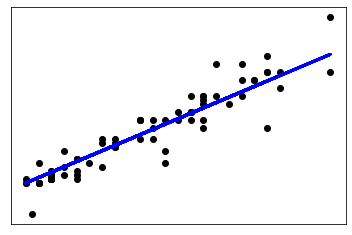

In [17]:
model.fit(X_train, y_train)
y_pred_cv = model.predict(X_cv)
y_pred_train = model.predict(X_train)


# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_cv, y_pred_cv))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_cv, y_pred_cv))

# Plot outputs
plt.scatter(X_cv, y_cv, color="black")
plt.plot(X_cv, y_pred_cv, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [18]:
train_mse = mean_squared_error(y_train, y_pred_train)
cv_mse = mean_squared_error(y_cv, y_pred_cv) 
print(f"Training MSE : {train_mse:.0f}")
print(f"Cross Validation MSE: {cv_mse: .0f}")

Training MSE : 306379946
Cross Validation MSE:  322126385


#### The results show that the both training and Cross Validation Bias and Variance are high. This maybe due to high bias (underfit). We could one or more of the following:

- Try adding additional features
- Try decreasing the regulatiztion parameter
- Try adding polynomial features

We will try the first option


### 2.1 Let's try adding more features, age, gender, and job title

In [19]:
X = salary_data[['Age', 'Job Title', 'Years of Experience', 'Gender', 'Job Title']]
y = salary_data['Salary']

### We will now split the data into train, cross validation, and test sets

In [20]:
X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_train_cv_test (X, y)

In [21]:
print(f" Training Data shape: {X_train.shape}")
print(f" Cross Validation Data shape: {X_cv.shape}")
print(f" Test Data shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

 Training Data shape: (223, 5)
 Cross Validation Data shape: (75, 5)
 Test Data shape: (75, 5)
y_train shape: (223,)


In [22]:
# The data has different range of values, for example age and years of experience have a large range than 
# Gender and Educational Level.  We want to scale the data into new values that are easier to compare
# We will use scikit-learn's StandardScaler
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_cv_scaled = scale.fit_transform(X_cv)
X_test_scaled = scale.fit_transform(X_test)

### 2.3 Explore the results

In [25]:
model.fit(X_train_scaled, y_train)
y_pred_cv = model.predict(X_cv_scaled)
y_pred_train = model.predict(X_train_scaled)

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_cv, y_pred_cv))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_cv, y_pred_cv))

Coefficients: 
 [12262.69064255  1295.8949297  31524.37056416  4124.46228041
  1295.8949297 ]
Mean squared error: 320780073.17
Coefficient of determination: 0.88


In [26]:

y_pred_train = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_pred_train)
cv_mse = mean_squared_error(y_cv, y_pred_cv)
print(f"Training MSE : {train_mse:.0f}")
print(f"Cross Validation MSE: {cv_mse: .0f}")

Training MSE : 278971519
Cross Validation MSE:  320780073


The accuracy the same as the model with only one feature (Job Experience).  Can we do better?

### 3.1 Let's try adding polynomial features

In [27]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_mapped = poly.fit_transform(X_train)
X_cv_mapped = poly.fit_transform(X_cv)
X_test_mapped = poly.fit_transform(X_test)

In [28]:
X_train_mapped_scaled = scale.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scale.fit_transform(X_cv_mapped)
X_test_mapped_scaled = scale.fit_transform(X_test_mapped)

###  3.2 Train our model

In [29]:
model.fit(X_train_mapped_scaled, y_train)


LinearRegression()

### 3.3 Explore the results

In [30]:
y_pred_cv = model.predict(X_cv_mapped_scaled)
y_pred_train = model.predict(X_train_mapped_scaled)

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_cv, y_pred_cv))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_cv, y_pred_cv))

Coefficients: 
 [-3.91763170e+06 -1.00614990e+05  4.15305075e+06 -6.90376010e+02
 -1.00614990e+05  1.17526322e+07  1.16103972e+05 -1.65391892e+07
 -5.08358185e+04  1.16103972e+05  6.58102474e+04 -2.84823907e+04
  2.27425745e+04  6.58102474e+04  4.40568488e+06  4.47126371e+04
 -2.84823907e+04 -6.90376004e+02  2.27425745e+04  6.58102474e+04
 -9.19662172e+06  5.69950677e+04  1.64815197e+07  1.73766311e+05
  5.69950677e+04 -7.46249512e+04 -8.23940927e+04 -7.94176231e+04
 -7.46249512e+04 -8.44799041e+06 -1.82041876e+05 -8.23940927e+04
 -5.08358185e+04 -7.94176231e+04 -7.46249512e+04 -8.89860024e+03
  3.15853867e+04  4.77738519e+03 -8.89860024e+03  1.49172962e+04
  2.52459729e+04  3.15853867e+04  2.27425745e+04  4.77738519e+03
 -8.89860024e+03  1.36076280e+06  2.85156093e+04  1.49172962e+04
  4.47126371e+04  2.52459729e+04  3.15853867e+04 -6.90376004e+02
  2.27425745e+04  4.77738519e+03 -8.89860024e+03]
Mean squared error: 245246982.06
Coefficient of determination: 0.91


In [31]:
y_pred_cv = model.predict(X_cv_mapped_scaled)
y_pred_train = model.predict(X_train_mapped_scaled)
train_mse = mean_squared_error(y_train, y_pred_train)
cv_mse = mean_squared_error(y_cv, y_pred_cv)
print(f"Training MSE : {train_mse:.0f}")
print(f"Cross Validation MSE: {cv_mse: .0f}")

Training MSE : 213109274
Cross Validation MSE:  245246982


The model is more accurate with degree 2

### 4.1 Let's try various degrees of polynomial to see if our model gets more accurate

In [32]:
def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:
        print(f"Dgree {degree}:")
        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat)
        print(f"     Train mse: {train_mse: .0f}")
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat)
        print(f"     cv mse: {cv_mse: .0f}")
        cv_mses.append(cv_mse)
        print (f"     MSE delta: {abs(cv_mse-train_mse): .0f}")
        print(f"      Coefficient of determination (r2 score): {r2_score(y_cv, yhat): .2f}")

    # Plot the results
    
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

In [33]:
X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_train_cv_test (X, y)

In [34]:
print(f" Training Data shape: {X_train.shape}")
print(f" Cross Validation Data shape: {X_cv.shape}")
print(f" Test Data shape: {X_test.shape}")

 Training Data shape: (223, 5)
 Cross Validation Data shape: (75, 5)
 Test Data shape: (75, 5)


Dgree 1:
     Train mse:  278971519
     cv mse:  311593536
     MSE delta:  32622017
      Coefficient of determination (r2 score):  0.88
Dgree 2:
     Train mse:  246224664
     cv mse:  266325081
     MSE delta:  20100417
      Coefficient of determination (r2 score):  0.90
Dgree 3:
     Train mse:  213109274
     cv mse:  225327409
     MSE delta:  12218135
      Coefficient of determination (r2 score):  0.92
Dgree 4:
     Train mse:  158774489
     cv mse:  1021247386
     MSE delta:  862472897
      Coefficient of determination (r2 score):  0.62
Dgree 5:
     Train mse:  90293603
     cv mse:  55362825665
     MSE delta:  55272532062
      Coefficient of determination (r2 score): -19.73
Dgree 6:
     Train mse:  35061619
     cv mse:  113175647043
     MSE delta:  113140585424
      Coefficient of determination (r2 score): -41.39
Dgree 7:
     Train mse:  4844522
     cv mse:  66340084800887144448
     MSE delta:  66340084800882302976
      Coefficient of determination (r2 score)

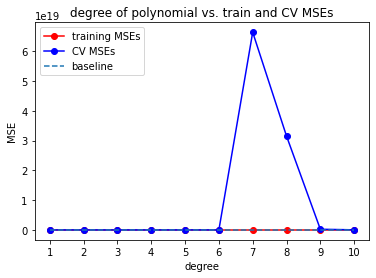

In [35]:
train_plot_poly(model, X_train, y_train, X_cv, y_cv, max_degree =10, baseline= 122122122)

### Conclusion:  Based on the analysis above, a regression model with additional features (original features + 3 degree polynomial) performs the best.
- The accuracy is 91%
- MSE for Training and Cross Validation dataset are the lowest and close to each other